In [14]:
# http://dlib.net/face_recognition.py.html
%matplotlib inline
import matplotlib.pyplot
from matplotlib.pyplot import imshow
import sys
import os
import dlib
import glob
from skimage import io
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import imutils
import cv2
from sklearn.decomposition import PCA
from scipy.spatial import distance
import numpy as np
from PIL import Image

In [15]:
predictor_path = "shape_predictor_68_face_landmarks.dat"
face_rec_model_path = "dlib_face_recognition_resnet_model_v1.dat"
faces_folder_path = "images"
out_folder_path = "faces"

In [4]:
detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor(predictor_path)
fa = FaceAligner(sp, desiredFaceWidth=512) 
facerec = dlib.face_recognition_model_v1(face_rec_model_path)


In [32]:
win = dlib.image_window()
i=0

In [34]:
# Now process all the images
features = []
images = []
for f in glob.glob(os.path.join(faces_folder_path, "*.jpg")):
    print("Processing file: {}".format(f))
    img = io.imread(f)
    #win.clear_overlay()
    #win.set_image(img)

    # Ask the detector to find the bounding boxes of each face. The 1 in the
    # second argument indicates that we should upsample the image 1 time. This
    # will make everything bigger and allow us to detect more faces.
    dets = detector(img, 1)
    print("Number of faces detected: {}".format(len(dets)))

    # Now process each face we found.
    for k, d in enumerate(dets):
        i=i+1
        faceAligned = fa.align(img, img, d)
        dets2 = detector(faceAligned, 1)
        shape_new = sp(faceAligned, dets2[0])
        face_descriptor = facerec.compute_face_descriptor(faceAligned, shape_new)
        features.append(face_descriptor)
        win.set_image(faceAligned)
        win.clear_overlay()
        win.add_overlay(dets2[0])
        win.add_overlay(shape_new)
        crop_img = faceAligned[dets2[0].top():dets2[0].bottom(),dets2[0].left():dets2[0].right()]
        images.append(crop_img)
        crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
        cv2.imwrite(os.path.join(out_folder_path,faces_folder_path+"_"+str(i)+".jpg"),crop_img)
        # print to txt file
        #print(face_descriptor)
        """
        win.clear_overlay()
        win.set_image(faceAligned)
        print("k:")
        print(k)
        print("d:")
        print(d)
        print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
            k, d.left(), d.top(), d.right(), d.bottom()))
        # Get the landmarks/parts for the face in box d.
        shape = sp(img, d)
        # Draw the face landmarks on the screen so we can see what face is currently being processed.
        #win.clear_overlay()
        #win.add_overlay(d)
        #win.add_overlay(shape)

        # Compute the 128D vector that describes the face in img identified by
        # shape.  In general, if two face descriptor vectors have a Euclidean
        # distance between them less than 0.6 then they are from the same
        # person, otherwise they are from different people. Here we just print
        # the vector to the screen.
        #face_descriptor = facerec.compute_face_descriptor(img, shape)
        #print(face_descriptor)
        #dlib.hit_enter_to_continue()
        """

Processing file: images\alg-pitt-jolie-fam-jpg.jpg
Number of faces detected: 4
Processing file: images\angelina-jolie-1-t.jpg
Number of faces detected: 5
Processing file: images\Angelina-Jolie-and-Brad-Pitt.jpg
Number of faces detected: 3
Processing file: images\brad-and-angelina-married-ftr.jpg
Number of faces detected: 2
Processing file: images\family.jpg
Number of faces detected: 4
Processing file: images\nethika(5).jpg
Number of faces detected: 2
Processing file: images\nethika(6).jpg
Number of faces detected: 1
Processing file: images\test (1).jpg
Number of faces detected: 1
Processing file: images\test (10).jpg
Number of faces detected: 3
Processing file: images\test (11).jpg
Number of faces detected: 0
Processing file: images\test (12).jpg
Number of faces detected: 1
Processing file: images\test (3).jpg
Number of faces detected: 3
Processing file: images\test (4).jpg
Number of faces detected: 2
Processing file: images\test (5).jpg
Number of faces detected: 2
Processing file: ima

IndexError: Index out of range

In [35]:
len(images)

40

In [36]:
features = np.array(features)
pca = PCA(n_components=100)
pca.fit(features)
pca_features = pca.transform(features)

In [37]:
def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.euclidean(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    dis_closest = sorted(distances)[1:num_results+1]
    return (idx_closest, dis_closest)

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = images[idx]
        img = Image.fromarray(img.astype('uint8'), 'RGB')
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

In [38]:
# do a query on a random image
#query_image_idx = int(len(images) * random.random())
query_image_idx = 10
print("Query image index", query_image_idx)
#print("Query image:", images[query_image_idx])
print("")
(idx_closest,dis_closest) = get_closest_images(query_image_idx)

for idx,dis in zip(idx_closest,dis_closest):
    print("image:",idx)
    print("distance:",dis)
    print("")

Query image index 10

image: 6
distance: 0.3290545597402665

image: 12
distance: 0.47698722920120107

image: 2
distance: 0.4810324908773062

image: 7
distance: 0.7742655228596432

image: 39
distance: 0.8239949249777728



Closest image indexes  : [6, 12, 2, 7, 39]
Closest image distances: [0.3290545597402665, 0.47698722920120107, 0.4810324908773062, 0.7742655228596432, 0.8239949249777728]


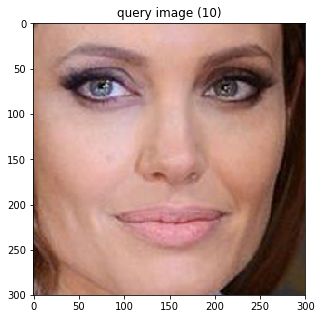

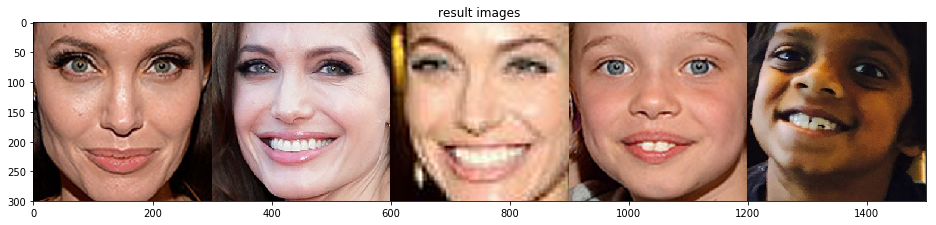

In [39]:
query_image = images[query_image_idx]
query_image_r = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 300)

# display the query image
matplotlib.pyplot.figure(figsize = (5,5))
imshow(query_image_r)
matplotlib.pyplot.title("query image (%d)" % query_image_idx)

# display the resulting images
matplotlib.pyplot.figure(figsize = (16,12))
imshow(results_image)
matplotlib.pyplot.title("result images")
print("Closest image indexes  :", idx_closest)
print("Closest image distances:", dis_closest)

In [176]:
#Classify



4

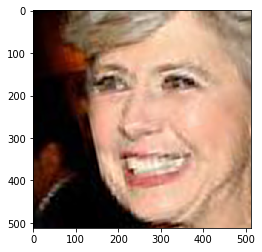

In [20]:
imshow(images[3])